In [1]:
import pickle as pk
import numpy as np
from normalization import *
import torch
from dataloader import combine_sparse_tensors
from tqdm import tqdm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

/home/yangxiaojie/anaconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [76]:
import pandas as pd
import pickle as pk
regions = pd.read_csv('/home/yangxiaojie/KDD2025/poi/FEA_hyoujun.csv')

def nan_to_empty_str(value):
    if pd.isna(value):
        return ''
    return str(value)

code2region = dict()
for i, row in regions.iterrows():
    code2region[str(row['標準地域コード']).zfill(5)] = row['都道府県'] + nan_to_empty_str(row['政令市･郡･支庁･振興局等']) + nan_to_empty_str(row['市区町村'])

region2code = dict(zip(list(code2region.values()), list(code2region.keys())))


with open('/home/yangxiaojie/KDD2025/selected_mesh.pk', 'rb') as f:
    selected_mesh = pk.load(f)

assert len(set(selected_mesh.values())) == reg_num

idx2code = dict(zip(list(range(reg_num)), sorted(set(selected_mesh.values()))))

code2idx = dict(zip(idx2code.values(),idx2code.keys()))

In [2]:
def data_scaler(data):
    data = torch.FloatTensor(data)
    scaler = StandardScaler(mean = data.mean(dim = 0), std = data.std(dim = 0))
    return scaler

In [3]:
interval = 4
reg_num = 490
treat_dim = 10
tim_num = 24
input_window = 24
output_window = 24
training_rate = 0.8
validate_rate = 0.1
test_rate = 0.1
causal = True

In [4]:
with open('/home/yangxiaojie/KDD2025/model/data/odmetrics_sparse_tensors.pk', 'rb') as f:
    adjacency_matrix = pk.load(f)

In [5]:
flows = np.load('/home/yangxiaojie/KDD2025/model/data/flows.npy')
flows = flows[:, ::interval, :]
flows = flows.reshape(len(adjacency_matrix), reg_num)

In [6]:
treatment_path = '/home/yangxiaojie/KDD2025/samples・説明書/treatment_scores_0618.pk'
with open(treatment_path, 'rb') as f:
    treatments = pk.load(f)

In [230]:
treat_dict = {}
alltreat = []

alltreat = np.zeros((len(adjacency_matrix), reg_num, treat_dim))
alltreat[:, :, 3] = 100

for d in treatments:
    for t in treatments[d]:
        treat_dict[d * tim_num + t] = {}
        for c in treatments[d][t]:
            treat = np.mean([_ for _ in treatments[d][t][c] if len(_) == treat_dim], axis = 0)
            if np.isnan(treat).any():
                treat = np.array([0, 0, 0, 100, 0, 0, 0, 0, 0, 0])
            treat[3] = 100 - treat[3]
            alltreat[d * tim_num + t, c] = treat

/home/yangxiaojie/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yangxiaojie/anaconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [235]:
treat_max = np.max(alltreat, axis=(0, 1), keepdims=True)

treat_min = np.min(alltreat, axis=(0, 1), keepdims=True)

alltreat = (alltreat - treat_min) / (treat_max - treat_min)

In [250]:
treat = torch.rand((128, 24, 64))
treat[0, -1, 0]

tensor(0.9004)

In [251]:
torch.flip(treat, [1])[0, 0, 0]

tensor(0.9004)

In [8]:
indices = []
for i in range(flows.shape[0]- input_window - output_window):
    indices.append(list(range(i, i + input_window + output_window)))

In [9]:
length = len(indices)
train_len = int(length * training_rate)
valid_len = int(length * validate_rate)
train_uplimit = indices[train_len][-1]
scaler = data_scaler(flows[:train_uplimit, :])

In [12]:
data = []
for index, indice in enumerate(tqdm(indices, desc="Processing")):
    x = scaler.transform(torch.FloatTensor(flows[indice[:input_window], :]))

    y = scaler.transform(torch.FloatTensor(flows[indice[input_window:], :]))
    if causal:
        treats = alltreat[indice[0] : indice[input_window], :, :]
    else:
        treats = None

    adj = combine_sparse_tensors(adjacency_matrix[indice[0] : indice[input_window]])
    indice = torch.LongTensor(indice)
    t = indice[:input_window] % tim_num  # 获取时间步
    t = t.unsqueeze(1).expand(-1, x.shape[1])  # 扩展时间步的维度

    data.append([indice, x, y, t, treats, adj])

Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8736/8736 [02:25<00:00, 59.99it/s]


In [16]:
data[0][4]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [17]:
def calculate_hour(hours_passed, start_date = '2023-04-01'):
    # 将起始日期转换为 datetime 对象
    start_datetime = datetime.strptime(start_date, '%Y-%m-%d')
    
    # 计算目标日期时间
    target_datetime = start_datetime + timedelta(hours=hours_passed)
    
    # 检查是否为周末
    is_weekend = target_datetime.weekday() >= 5  # 5 是周六，6 是周日
    
    # 计算目标小时（0-23 或 24-47）
    if is_weekend:
        result_hour = target_datetime.hour + 24
    else:
        result_hour = target_datetime.hour
    
    return result_hour

In [18]:
def calculate_week_hour(hours_passed, start_date = '2023-04-01'):
    # 将起始日期转换为 datetime 对象
    start_datetime = datetime.strptime(start_date, '%Y-%m-%d')
    
    # 计算目标日期时间
    target_datetime = start_datetime + timedelta(hours=hours_passed)
    
    # 计算从周开始的小时数（0-143）
    #days_since_week_start = target_datetime.weekday() # 星期一为0
    result_hour = target_datetime.weekday() * 24 + target_datetime.hour
    
    return result_hour

In [19]:
start_date = '2023-04-01'
start_datetime = datetime.strptime(start_date, '%Y-%m-%d')

# 计算目标日期时间
target_datetime = start_datetime + timedelta(hours=20)

In [45]:
def combine_sparse_tensors(tensor_list):
    batch_size = len(tensor_list)
    V = tensor_list[0].size(0)
    
    combined_indices = []
    combined_values = []

    # 遍历列表中的每个稀疏张量
    for i, tensor in enumerate(tensor_list):
        indices = tensor._indices()
        values = tensor._values()
        
        # 添加批次维度信息
        batch_indices = torch.cat([torch.full((1, indices.size(1)), i, dtype=torch.long), indices], dim=0)
        
        # 将当前张量的 indices 和 values 添加到组合列表中
        if len(combined_indices) == 0:
            combined_indices = batch_indices
            combined_values = values
        else:
            combined_indices = torch.cat((combined_indices, batch_indices), dim=1)
            combined_values = torch.cat((combined_values, values))

    # 新的张量大小
    size = torch.Size([batch_size, V, V])

    # 创建合并后的稀疏张量
    combined_tensor = torch.sparse_coo_tensor(combined_indices, combined_values, size=size)
    
    return combined_tensor

In [24]:
device = 'cuda:0'
causal_model = torch.load('/home/yangxiaojie/KDD2025/model/models/model_4617_1111_True.pth').to(device)

In [192]:
import pandas as pd
start_date = '2023-04-01 00:00:00'
target_time = '2023-07-28 00:00:00'
target_region = '東京都墨田区'
region_idx = code2idx[region2code[target_region]]

# 将日期字符串转换为 datetime 对象
start_date = pd.to_datetime(start_date)
target_time = pd.to_datetime(target_time)

# 计算时间差
time_difference = target_time - start_date

# 将时间差转换为小时数
time_idx = int(time_difference.total_seconds() / 3600)
print(region_idx)
print(time_idx)

145
2832


In [193]:
device = 'cuda:0'
indice, x, y, _, treat, adj = data[time_idx]
mask = None

causal_model.eval()

indice = torch.LongTensor(indice)
t = torch.LongTensor([calculate_week_hour(i.numpy().tolist()) for i in indice[:input_window]])
#t = indice[:self.args.input_window] % self.args.tim_num  # 获取时间步
t = t.unsqueeze(1).expand(-1, x.shape[1])  # 扩展时间步的维度

x = x.unsqueeze(0).unsqueeze(-1).to(device)
y = y.unsqueeze(0).to(device)
t = t.unsqueeze(0).to(device)
adj = adj.unsqueeze(0).to(device)
treat = torch.FloatTensor(treat).unsqueeze(0).to(device) / 100
treat_fake = torch.rand_like(treat)
y = y.permute(0, 2, 1)
y_pre, w, z, _ = causal_model(x, t, treat_fake, adj, mask)
y_pre = y_pre.unsqueeze(-1).reshape(y.shape)

preds = []
trues = []
for i in range(output_window):  
    y_pred = torch.flatten(scaler.inverse_transform(y_pre[:, :, i].cpu().squeeze())).detach().numpy().tolist()
    y_true = torch.flatten(scaler.inverse_transform(y[:, :, i].cpu().squeeze())).detach().numpy().tolist()
    preds.append(y_pred[region_idx])
    trues.append(y_true[region_idx])

In [194]:
w[region_idx, :]

tensor([0.3497, 0.3197, 0.2888, 0.2601, 0.2470, 0.2412, 0.2453, 0.2518, 0.2693,
        0.2738, 0.2809, 0.2978, 0.2980, 0.2952, 0.3074, 0.3104, 0.3144, 0.3206,
        0.3150, 0.3159, 0.2923, 0.2788, 0.2734, 0.2725], device='cuda:0',
       grad_fn=<SliceBackward0>)

tensor([[0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0

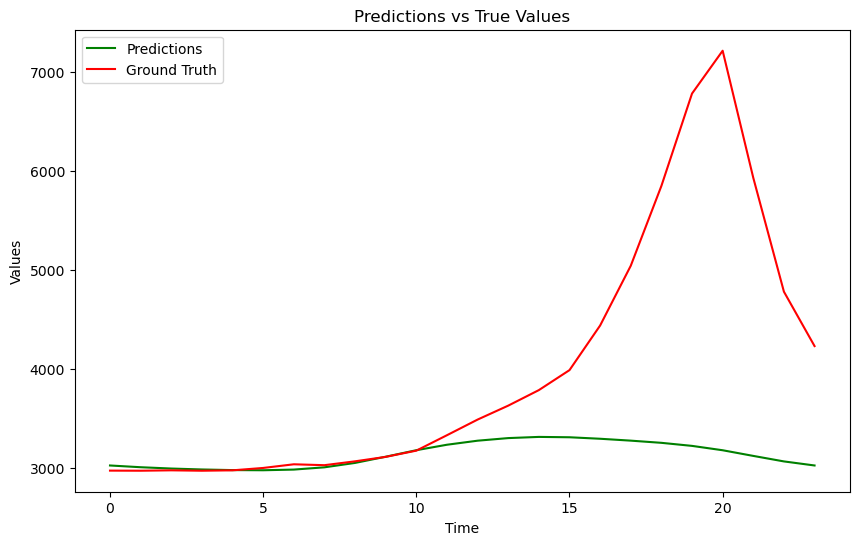

In [196]:
plt.figure(figsize=(10, 6))
plt.plot(preds, label='Predictions', color='g')
plt.plot(trues, label='Ground Truth', color='r')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Predictions vs True Values')
plt.legend()
plt.show()

In [202]:
treat[0, :, region_idx, :][, :]

tensor([], device='cuda:0', size=(0, 10))